In [ ]:
"""
SACAR LOS LINKS DE LAS CANCIONES DEL ARTISTA
"""
import requests
from bs4 import BeautifulSoup

# URL of the artist's page (change this to the correct artist URL)
artist_url = "https://www.letras.com/joaquin-sabina/"

# Fetch the HTML content
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(artist_url, headers=headers)

# Parse HTML
soup = BeautifulSoup(response.text, "html.parser")

# Find all the song links
song_links = []
# Find all <a> tags with href attributes
for link in soup.find_all("a", href=True):
    href = link['href']
    
    # Skip links that contain 'discografia' or the generic artist link
    if "discografia/" in href.lower() or "contribuicoes/" in href.lower() or href == "/joaquin-sabina/":
        continue
    
    # Check if the href contains the song ID pattern (e.g., /joaquin-sabina/{song_id}/)
    if "/joaquin-sabina/" in href and href.endswith('/'):
        full_url = "https://www.letras.com" + href
        song_links.append(full_url)

# Remove duplicates by converting to a set and back to a list
song_links = list(set(song_links))

# Save the song links to a file (song_links.txt)
with open("song_links.txt", "w", encoding="utf-8") as file:
    for link in song_links:
        file.write(link + "\n")

print(f"Saved {len(song_links)} song links to 'song_links.txt'")


In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import re  # Para manejar expresiones regulares y extraer el ID

# Leer la lista de URLs de canciones desde el archivo
with open("song_links.txt", "r", encoding="utf-8") as file:
    song_urls = [line.strip() for line in file.readlines()]

# Preparar almacenamiento de los datos
songs_data = []

# Recorrer cada URL y extraer los datos
for url in song_urls:
    # Obtener HTML
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    # Extraer el título y el artista de la canción
    titulo = soup.find("h1", class_="textStyle-primary").text.strip()
    artista = soup.find("h2", class_="textStyle-secondary").text.strip()

    # Extraer la letra
    letra_div = soup.find("div", class_="lyric-original")
    if letra_div:
        letra = " // ".join([p.get_text(strip=True) for p in letra_div.find_all("p")])
    else:
        letra = "No lyrics found"

    # Extraer el ID de la canción (si está en el URL o en algún lugar específico de la página)
    # Aquí hago un ejemplo de cómo extraer el número del ID de la URL, puedes ajustarlo según cómo sea el formato
    match = re.search(r"/(\d+)", url)  # Suponiendo que el ID está en la URL, ejemplo: /255831
    if match:
        song_id = match.group(1)  # El número extraído de la URL
    else:
        # Si no se encuentra el ID en la URL, podrías usar el nombre de la canción como ID
        song_id = titulo

    # Guardar los datos de la canción
    songs_data.append({
        "title": titulo,
        "artist": artista,
        "id": song_id,  # Aquí se almacena el ID
        "lyrics": letra
    })

# Guardar en un archivo JSON
json_filename = "songs_data.json"
with open(json_filename, "w", encoding="utf-8") as jsonfile:
    json.dump({"songs": songs_data}, jsonfile, ensure_ascii=False, indent=4)

print(f"Data saved successfully in {json_filename}")


In [ ]:
"""
CREAR ESPACIOS ENTRE LAS LETRAS, se almacenan como: ansiasComo y pasa a ansias Como
"""
import json

# Function to insert space between lowercase and uppercase letters
def add_space_between_case(text):
    if not text:  # Check if the text is empty
        return text  # Return the empty string if no content

    corrected_text = ""
    for i in range(len(text) - 1):
        # Check if the current character is lowercase and the next is uppercase
        if text[i].islower() and text[i + 1].isupper():
            corrected_text += text[i] + " "  # Add space
        else:
            corrected_text += text[i]
    
    corrected_text += text[-1]  # Add the last character
    return corrected_text

# Load the JSON data from the file containing the songs
with open("songs_data.json", "r", encoding="utf-8") as jsonfile:
    songs_data = json.load(jsonfile)["songs"]

# Apply the function to each song's lyrics
for song in songs_data:
    song["lyrics"] = add_space_between_case(song["lyrics"])

# Save the corrected lyrics back to the JSON file
with open("songs_data_corrected.json", "w", encoding="utf-8") as jsonfile:
    json.dump({"songs": songs_data}, jsonfile, ensure_ascii=False, indent=4)

print("Data corrected and saved in 'songs_data_corrected.json'")

In [ ]:
"""
EXTRAER EXPLICACION DE LAS LETRAS
"""
import requests
from bs4 import BeautifulSoup
import json
import time

# Leer los enlaces de las canciones
with open("song_links.txt", "r") as file:
    song_links = [line.strip() for line in file.readlines()]

# Lista para almacenar los significados
song_meanings = []

# User-Agent para evitar bloqueos
HEADERS = {"User-Agent": "Mozilla/5.0"}

# Recorrer cada enlace
for song_url in song_links:
    try:
        # Construir la URL del significado
        meaning_url = song_url + "significado.html"

        # Hacer la solicitud
        response = requests.get(meaning_url, headers=HEADERS)
        
        # Si la página no existe, continuar con la siguiente
        if response.status_code != 200:
            print(f"⚠️ No se encontró significado para {song_url}")
            continue

        # Parsear la página con BeautifulSoup
        soup = BeautifulSoup(response.text, "html.parser")

        # Buscar la sección de significado
        meaning_section = soup.find("div", class_="lyric-meaning")
        
        if meaning_section:
            # Extraer todos los párrafos dentro del div
            paragraphs = [p.text.strip() for p in meaning_section.find_all("p")]
            meaning_text = " ".join(paragraphs)

            # Extraer el título de la canción (última parte de la URL)
            title = song_url.split("/")[-2].replace("-", " ").title()

            # Agregar al JSON
            song_meanings.append({"title": title, "meaning": meaning_text})
            print(f"✅ Extraído significado de {title}")
        else:
            print(f"⚠️ No se encontró la sección de significado en {song_url}")

        # Pequeña pausa para evitar bloqueos del servidor
        time.sleep(2)

    except Exception as e:
        print(f"❌ Error con {song_url}: {e}")

# Guardar en un archivo JSON
with open("sabina_significados.json", "w", encoding="utf-8") as json_file:
    json.dump(song_meanings, json_file, ensure_ascii=False, indent=4)

print("✅ Significados guardados en 'sabina_significados.json'")


In [ ]:
"""
Extraer datos de album y año para clasificar
"""
import requests
from bs4 import BeautifulSoup
import json

# URL de la discografía en Letras.com
URL = "https://www.letras.com/joaquin-sabina/discografia/"

# Obtener el contenido HTML
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}
response = requests.get(URL, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

# Diccionario para almacenar los datos
discografia = {}

# Buscar todos los álbumes
albumes = soup.find_all("div", class_="songList-header --album --list")

for album in albumes:
    # Extraer nombre del álbum y año
    album_nombre = album.find("h1", class_="songList-header-name --biggest").text.strip()
    album_info = album.find("div", class_="songList-header-info").text.strip()
    
    # Extraer el año del álbum
    try:
        album_año = int(album_info.split()[0])
    except:
        album_año = "Desconocido"

    # Lista de canciones
    canciones = []
    canciones_list = album.find_next_sibling("div", class_="songList-table")
    
    if canciones_list:
        canciones_items = canciones_list.find_all("div", class_="songList-table-songName")  # Cambiar selector para obtener canciones
        for item in canciones_items:
            cancion_nombre = item.find("span").text.strip()  # Obtener el nombre de la canción
            canciones.append(cancion_nombre)

    # Guardar datos en el diccionario
    discografia[album_nombre] = {
        "año": album_año,
        "canciones": canciones
    }

# Guardar en un archivo JSON
with open("discografia_sabina.json", "w", encoding="utf-8") as file:
    json.dump(discografia, file, ensure_ascii=False, indent=4)

print("✅ Discografía guardada en 'discografia_sabina.json'")


In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Inicializar VADER
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(lyrics):
    blob_score = TextBlob(lyrics).sentiment.polarity  # -1 (neg) a 1 (pos)
    vader_score = analyzer.polarity_scores(lyrics)["compound"]  # -1 (neg) a 1 (pos)
    return {"textblob": blob_score, "vader": vader_score}

# Aplicar a todas las canciones
sentiments = [analyze_sentiment(lyrics) for lyrics in lyrics_list]

# Mostrar resultados de las primeras 5 canciones
for i, song in enumerate(data["songs"][:5]):
    print(f"{song['title']}: TextBlob={sentiments[i]['textblob']:.2f}, VADER={sentiments[i]['vader']:.2f}")


In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pysentimiento import create_analyzer
import json

# Cargar JSON
with open("songs_data_corrected.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extraer letras de canciones
lyrics_list = [song["lyrics"] for song in data["songs"]]

# Inicializar analizadores
vader_analyzer = SentimentIntensityAnalyzer()
pysent_analyzer = create_analyzer(task="sentiment", lang="es")

def analyze_sentiment(lyrics):
    """Aplica los tres modelos de sentimiento a las letras."""
    blob_score = TextBlob(lyrics).sentiment.polarity  # -1 (neg) a 1 (pos)
    vader_score = vader_analyzer.polarity_scores(lyrics)["compound"]  # -1 (neg) a 1 (pos)
    
    # PySentimiento devuelve una clase con .output (positivo, neutro o negativo) y .probas (probabilidades)
    pysent_result = pysent_analyzer.predict(lyrics)
    pysent_score = (
        pysent_result.probas["POS"] - pysent_result.probas["NEG"]
    )  # Normalizar entre -1 y 1

    return {"textblob": blob_score, "vader": vader_score, "pysentimiento": pysent_score}

# Aplicar a todas las canciones
sentiments = [analyze_sentiment(lyrics) for lyrics in lyrics_list]

# Mostrar resultados de las primeras 5 canciones
for i, song in enumerate(data["songs"][:7]):
    print(
        f"{song['title']}: TextBlob={sentiments[i]['textblob']:.2f}, "
        f"VADER={sentiments[i]['vader']:.2f}, PySentimiento={sentiments[i]['pysentimiento']:.2f}"
    )


In [ ]:
import json
import pandas as pd

# Leer el archivo song_data.json
with open('songs_data.json', 'r', encoding='utf-8') as file:
    song_data = json.load(file)

# Leer el archivo sabina_significado.json
with open('sabina_significados.json', 'r', encoding='utf-8') as file:
    sabina_significado = json.load(file)

# Leer el archivo discografia_sabina.json
with open('discografia_sabina.json', 'r', encoding='utf-8') as file:
    discografia_sabina = json.load(file)

# Crear un diccionario para buscar el significado de las canciones por su ID
meaning_dict = {item['title']: item['meaning'] for item in sabina_significado}

# Preparar la lista de datos que se incluirán en el DataFrame
data = []

# Iterar sobre las canciones de cada álbum
for album, album_data in discografia_sabina.items():
    for song_title in album_data['canciones']:
        # Buscar el ID de la canción en song_data.json
        song_info = next((item for item in song_data['songs'] if item['title'] == song_title), None)
        
        if song_info:
            song_id = song_info['id']
            lyrics = song_info['lyrics'].replace(' // ', ' ')  # Eliminar los `//` de las letras
            explanation = meaning_dict.get(str(song_id), "Explicación no disponible")  # Obtener la explicación de la canción
            release_year = album_data['año']

            # Agregar la información al listado de datos
            data.append({
                'nombreCancion': song_title,
                'id': song_id,
                'fecha': release_year,
                'letraCancion': lyrics,
                'explicacionLetra': explanation,
                'nombreDisco': album
            })

# Crear el DataFrame con pandas
df = pd.DataFrame(data)

# Guardar el DataFrame en un archivo CSV o visualizarlo
df.to_csv('canciones_sabina.csv', index=False, encoding='utf-8')
print(df.head())  # Mostrar las primeras filas del DataFrame


In [ ]:
df = df[~df["nombreDisco"].str.contains("En Directo", na=False)]
print(df.head())

In [ ]:
print(df)

In [ ]:
num_canciones = df[df["fecha"] < 2001].shape[0]
print(f"Número de canciones en álbumes anteriores a 2001: {num_canciones}")

cancionesprev = df[df["fecha"] < 2001]
#cancionesprev = df[df["fecha"] >= 2001]
print(cancionesprev.head())

In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pysentimiento import create_analyzer

# Assuming 'cancionesprev' is already filtered from the original DataFrame
lyrics_list = cancionesprev["letraCancion"].tolist()

# Initialize analyzers
vader_analyzer = SentimentIntensityAnalyzer()
pysent_analyzer = create_analyzer(task="sentiment", lang="es")

def analyze_sentiment(lyrics):
    """Applies sentiment analysis using three models."""
    blob_score = TextBlob(lyrics).sentiment.polarity  # -1 (neg) to 1 (pos)
    vader_score = vader_analyzer.polarity_scores(lyrics)["compound"]  # -1 (neg) to 1 (pos)
    
    # PySentimiento returns a class with .output (pos, neutral, neg) and .probas (probabilities)
    pysent_result = pysent_analyzer.predict(lyrics)
    pysent_score = pysent_result.probas["POS"] - pysent_result.probas["NEG"]  # Normalize to -1 to 1

    return {"textblob": blob_score, "vader": vader_score, "pysentimiento": pysent_score}

# Apply sentiment analysis to all songs in 'cancionesprev'
sentiments = [analyze_sentiment(lyrics) for lyrics in lyrics_list]

# Add sentiment analysis results to the DataFrame
cancionesprev["TextBlob"] = [s["textblob"] for s in sentiments]
cancionesprev["VADER"] = [s["vader"] for s in sentiments]
cancionesprev["PySentimiento"] = [s["pysentimiento"] for s in sentiments]

# Print the first few results
print(cancionesprev[["nombreCancion", "TextBlob", "VADER", "PySentimiento"]].head())

# Optionally, save to a new Excel file
cancionesprev.to_excel("canciones_sentimientopost.xlsx", index=False)


In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pysentimiento import create_analyzer

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
pysent_analyzer = create_analyzer(task="sentiment", lang="es")

def analyze_sentiment(text):
    """Applies sentiment analysis using TextBlob, VADER, and PySentimiento."""
    blob_score = TextBlob(text).sentiment.polarity  # -1 (neg) to 1 (pos)
    vader_score = vader_analyzer.polarity_scores(text)["compound"]  # -1 (neg) to 1 (pos)
    
    # PySentimiento returns a class with .output (pos, neutral, neg) and .probas (probabilities)
    pysent_result = pysent_analyzer.predict(text)
    pysent_score = pysent_result.probas["POS"] - pysent_result.probas["NEG"]  # Normalize to -1 to 1

    return blob_score, vader_score, pysent_score

# Apply sentiment analysis for both lyrics and explanation
cancionesprev[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]] = cancionesprev["letraCancion"].apply(lambda x: analyze_sentiment(x)).apply(pd.Series)
cancionesprev[["TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]] = cancionesprev["explicacionLetra"].apply(lambda x: analyze_sentiment(x)).apply(pd.Series)

# Print sample results
print(cancionesprev[["nombreCancion", "TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra", 
                     "TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].head())

# Save results to an Excel file
cancionesprev.to_excel("canciones_sentimientotdoprev.xlsx", index=False)


In [ ]:
import pandas as pd

#df = pd.read_csv('canciones_sabina_tituloExplicacion.csv')

#df1 = pd.read_csv('cancionesAll_Post2001')
#df2 = pd.read_csv('cancionesAll_Post2001')
dfpost = pd.read_excel('cancionesAll_Prev2001.xlsx')
dfprev = pd.read_excel('cancionesAll_Post2001.xlsx')
df = dfs[dfs["fecha"] < 2001]
print(df) 

In [ ]:
frames = [dfpost,dfprev]
result = pd.concat(frames)



In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pysentimiento import create_analyzer

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
pysent_analyzer = create_analyzer(task="sentiment", lang="es")

def analyze_sentiment(text):
    """Applies sentiment analysis using TextBlob, VADER, and PySentimiento."""
    blob_score = TextBlob(text).sentiment.polarity  # -1 (neg) to 1 (pos)
    vader_score = vader_analyzer.polarity_scores(text)["compound"]  # -1 (neg) to 1 (pos)
    
    # PySentimiento returns a class with .output (pos, neutral, neg) and .probas (probabilities)
    pysent_result = pysent_analyzer.predict(text)
    pysent_score = pysent_result.probas["POS"] - pysent_result.probas["NEG"]  # Normalize to -1 to 1

    return blob_score, vader_score, pysent_score

# Apply sentiment analysis for both lyrics and explanation
result[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]] = result["letraCancion"].apply(lambda x: analyze_sentiment(x)).apply(pd.Series)
result[["TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]] = result["explicacionLetra"].apply(lambda x: analyze_sentiment(x)).apply(pd.Series)

# Print sample results
print(result[["nombreCancion", "TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra", 
                     "TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].head())

# Save results to an Excel file
result.to_excel("canciones_sentimientotdoCompleto.xlsx", index=False)


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



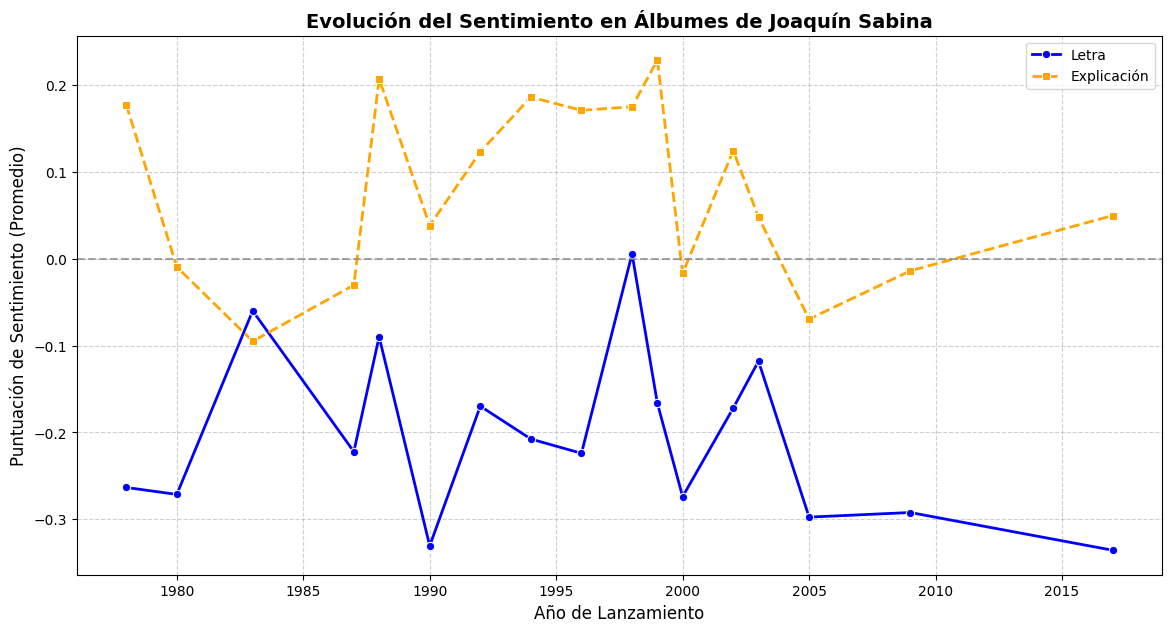

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
file_path = "canciones_sentimientotdoCompleto.xlsx"
df = pd.read_excel(file_path)

# Normalizar nombres de álbumes
df['nombreDisco'] = df['nombreDisco'].str.strip()

# Calcular la media de sentimiento por álbum
df_grouped = df.groupby("nombreDisco")[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra",
                                      "TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].mean().reset_index()

# Calcular sentimiento promedio por álbum
df_grouped["Sentimiento_Letra"] = df_grouped[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]].mean(axis=1)
df_grouped["Sentimiento_Explicacion"] = df_grouped[["TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].mean(axis=1)

# Unir con los años de lanzamiento y ordenar cronológicamente
album_years = df[['nombreDisco', 'fecha']].drop_duplicates()
df_grouped = df_grouped.merge(album_years, on="nombreDisco").sort_values("fecha")

# Calcular la edad de Joaquín Sabina (nació en 1949)
df_grouped['Edad_Sabina'] = df_grouped['fecha'] - 1949

# Configurar el gráfico
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_grouped, x="fecha", y="Sentimiento_Letra", label="Letra", marker="o", linestyle='-', linewidth=2, color='blue')
sns.lineplot(data=df_grouped, x="fecha", y="Sentimiento_Explicacion", label="Explicación", marker="s", linestyle='--', linewidth=2, color='orange')

# Anotaciones de eventos clave
eventos = {2001: "Infarto cerebral"}
for year, event in eventos.items():
    if year in df_grouped['fecha'].values:
        y_pos = df_grouped[df_grouped['fecha'] == year]['Sentimiento_Letra'].values[0]
        plt.annotate(event, xy=(year, y_pos), xytext=(year - 5, y_pos + 0.1),
                     arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12, color='red')

# Personalizar ejes y título
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # Línea de neutralidad
plt.title("Evolución del Sentimiento en Álbumes de Joaquín Sabina", fontsize=14, fontweight='bold')
plt.xlabel("Año de Lanzamiento", fontsize=12)
plt.ylabel("Puntuación de Sentimiento (Promedio)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar gráfico
plt.show()


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



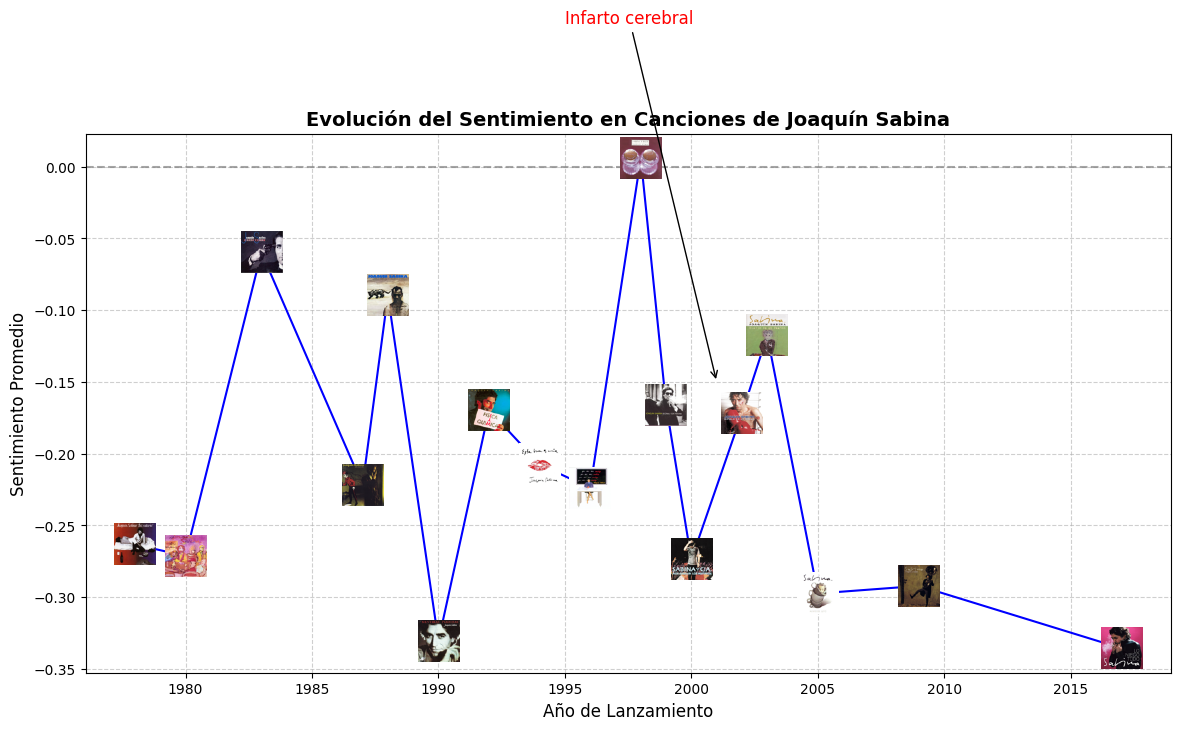

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


from PIL import Image
import os

# Cargar los datos desde el archivo Excel
file_path = "canciones_sentimientotdoCompleto.xlsx"
df = pd.read_excel(file_path)

# Normalizar nombres de álbumes para evitar problemas de espacios y tildes
df['nombreDisco_normalized'] = df['nombreDisco'].str.strip().str.lower()

# Calcular la media de los sentimientos por álbum
df_grouped = df.groupby("nombreDisco_normalized")[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]].mean()
df_grouped["Sentimiento_Letra"] = df_grouped.mean(axis=1)
df_grouped = df_grouped.reset_index()

# Agregar la fecha y ordenar por orden cronológico
df_dates = df[['nombreDisco_normalized', 'fecha']].drop_duplicates()
df_grouped = df_grouped.merge(df_dates, on='nombreDisco_normalized', how='left')
df_grouped = df_grouped.sort_values(by="fecha")

# Calcular la edad de Joaquín Sabina en cada álbum
df_grouped["Edad_Sabina"] = df_grouped["fecha"] - 1949

# Asignar rutas de imágenes de los álbumes
album_images = {
    "19 días y 500 noches": "imagenes/19_Días_y_500_Noches.jpg",
    "alivio de luto": "imagenes/Alivio_de_Luto.jpg",
    "diario de un peatón": "imagenes/Diario_De_Un_Peatón.jpg",
    "dímelo en la calle": "imagenes/Dímelo_En_La_Calle.jpg",
    "el hombre del traje gris": "imagenes/El_Hombre_del_Traje_Gris.jpg",
    "enemigos íntimos": "imagenes/Enemigos_Íntimos.jpg",
    "física y química": "imagenes/Física_y_Química.jpg",
    "hotel, dulce hotel": "imagenes/Hotel,_Dulce_Hotel.jpg",
    "inventario": "imagenes/Inventario.jpg",
    "lo niego todo": "imagenes/Lo_Niego_Todo.jpg",
    "malas compañías": "imagenes/Malas_Compañías.jpg",
    "mentiras piadosas": "imagenes/Mentiras_Piadosas.jpg",
    "nos sobran los motivos": "imagenes/Nos_Sobran_Los_Motivos.jpg",
    "ruleta rusa": "imagenes/Ruleta_Rusa.jpg",
    "vinagre y rosas": "imagenes/Vinagre_y_Rosas.jpg",
    "esta boca es mía": "imagenes/Esta_Boca_Es_Mía.jpg",
    "yo, mí, me, contigo": "imagenes/Yo,_Mí,_Me,_Contigo.jpg"
}

# Crear la figura
fig, ax = plt.subplots(figsize=(14, 7))

# Graficar la evolución del sentimiento con una línea
sns.lineplot(data=df_grouped, x="fecha", y="Sentimiento_Letra", marker="", linestyle="-", color="blue", ax=ax)

# Agregar imágenes de los álbumes en los puntos
for _, row in df_grouped.iterrows():
    album_name = row["nombreDisco_normalized"]
    if album_name in album_images and os.path.exists(album_images[album_name]):
        img = Image.open(album_images[album_name])
        img = img.resize((60, 60))  # Ajustar tamaño
        imagebox = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(imagebox, (row["fecha"], row["Sentimiento_Letra"]), frameon=False, pad=0.1)
        ax.add_artist(ab)

# Agregar línea de referencia en 0
ax.axhline(0, color='gray', linestyle='--', alpha=0.7)

# Anotar evento clave: Infarto cerebral en 2001
ax.annotate("Infarto cerebral", xy=(2001, -0.15), xytext=(1995, 0.1),
            arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=12, color='red')

# Mejorar estética del gráfico
ax.set_title("Evolución del Sentimiento en Canciones de Joaquín Sabina", fontsize=14, fontweight="bold")
ax.set_xlabel("Año de Lanzamiento", fontsize=12)
ax.set_ylabel("Sentimiento Promedio", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Mostrar gráfico
plt.show()


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



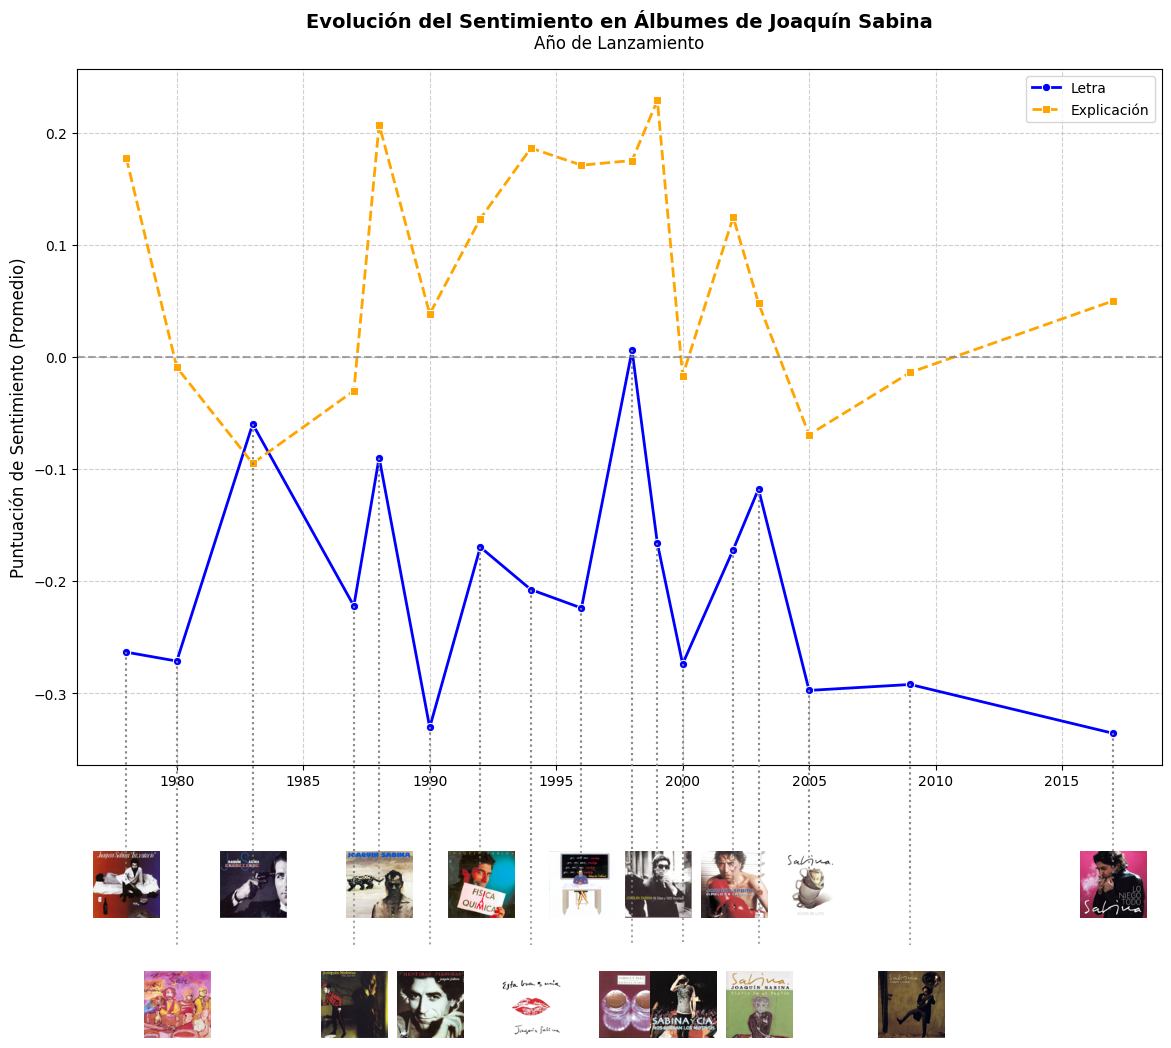

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os
import numpy as np

# Cargar datos
file_path = "canciones_sentimientotdoCompleto.xlsx"
df = pd.read_excel(file_path)

# Normalizar nombres de álbumes
df['nombreDisco'] = df['nombreDisco'].str.strip().str.replace('á', 'a').str.replace('é', 'e')

# Calcular la media de sentimiento por álbum
df_grouped = df.groupby("nombreDisco")[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra",
                                      "TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].mean().reset_index()

# Calcular sentimiento promedio por álbum
df_grouped["Sentimiento_Letra"] = df_grouped[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]].mean(axis=1)
df_grouped["Sentimiento_Explicacion"] = df_grouped[["TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].mean(axis=1)

# Unir con los años de lanzamiento y ordenar cronológicamente
album_years = df[['nombreDisco', 'fecha']].drop_duplicates()
df_grouped = df_grouped.merge(album_years, on="nombreDisco").sort_values("fecha")
#df_grouped["nombreDisco"] = df_grouped["nombreDisco"].str.lower().str.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace(',', '').replace(' ', '_')
df_grouped["nombreDisco"] = df_grouped["nombreDisco"].str.lower().str.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace(',', '').replace(' ', '_')
#df_grouped["nombreDisco"] = df_grouped["nombreDisco"].str.lower().str.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace(',', '').str.replace(' ', '_')


# Calcular la edad de Joaquín Sabina (nació en 1949)
df_grouped['Edad_Sabina'] = df_grouped['fecha'] - 1949

base_path = "C:/Users/Juan/Desktop/Proyectos/canciones/JoaquinSabina/imagenes/"

# Asignar las rutas de las imágenes de los álbumes (sin duplicación de directorios)
album_images = {
    "19 días y 500 noches": "19_Días_y_500_Noches.jpg",
    "alivio de luto": "Alivio_de_Luto.jpg",
    "diario de un peatón": "Diario_De_Un_Peatón.jpg",
    "dímelo en la calle": "Dímelo_En_La_Calle.jpg",
    "el hombre del traje gris": "El_Hombre_del_Traje_Gris.jpg",
    "enemigos íntimos": "Enemigos_Íntimos.jpg",
    "física y química": "Física_y_Química.jpg",
    "hotel, dulce hotel": "Hotel,_Dulce_Hotel.jpg",
    "inventario": "Inventario.jpg",
    "lo niego todo": "Lo_Niego_Todo.jpg",
    "malas compañías": "Malas_Compañías.jpg",
    "mentiras piadosas": "Mentiras_Piadosas.jpg",
    "nos sobran los motivos": "Nos_Sobran_Los_Motivos.jpg",
    "ruleta rusa": "Ruleta_Rusa.jpg",
    "vinagre y rosas": "Vinagre_y_Rosas.jpg",
    "esta boca es mía": "Esta_Boca_Es_Mía.jpg",
    "yo, mí, me, contigo": "Yo,_Mí,_Me,_Contigo.jpg"
}

# Actualizar las rutas de las imágenes para que no se repita "imagenes/"
album_image = {album: os.path.join(base_path, path) for album, path in album_images.items()}
album_images = {k.lower().strip(): v for k, v in album_images.items()}

# Configurar el gráfico con más espacio en la parte inferior
fig, ax = plt.subplots(figsize=(14, 12))
plt.subplots_adjust(bottom=0.3)  # Dejar más espacio en la parte inferior para las imágenes

# Graficar la evolución del sentimiento con una línea
sns.lineplot(data=df_grouped, x="fecha", y="Sentimiento_Letra", label="Letra", marker="o", linestyle='-', linewidth=2, color='blue', ax=ax)
sns.lineplot(data=df_grouped, x="fecha", y="Sentimiento_Explicacion", label="Explicación", marker="s", linestyle='--', linewidth=2, color='orange', ax=ax)

# Obtener límites del gráfico
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Crear una transformación para coordenadas de figura (0-1)
fig_trans = fig.transFigure.inverted()

# Altura fija para las imágenes (debajo del gráfico)
# Alternar posiciones de imágenes
for i, row in enumerate(df_grouped.itertuples()):
    x_data = row.fecha
    y_data = row.Sentimiento_Letra
    x_fig, y_fig = ax.transData.transform((x_data, y_data))  
    x_fig, y_fig = fig_trans.transform((x_fig, y_fig))  
    
    # Alternar altura para evitar colisiones
    image_y_pos = image_height + (0.05 if i % 2 == 0 else -0.05)

    line = plt.Line2D([x_fig, x_fig], [y_fig, image_y_pos + 0.05], 
                     transform=fig.transFigure, color='gray', linestyle=':', alpha=0.7)
    fig.lines.append(line)

    album_name = row.nombreDisco
    if album_name in album_image and os.path.exists(album_image[album_name]):
        try:
            img = Image.open(album_image[album_name])
            img = img.resize((80, 80))
            imagebox = OffsetImage(img, zoom=0.6)
            
            ab = AnnotationBbox(imagebox, (x_fig, image_y_pos), 
                              xycoords=fig.transFigure,
                              frameon=False, boxcoords="offset points", pad=0)
            ax.add_artist(ab)
        except Exception as e:
            print(f"No se pudo cargar la imagen para {album_name}: {e}")
    else:
        print(f"No se encontró la imagen para {album_name}")


# Dibujar líneas verticales desde los puntos hasta las imágenes
for _, row in df_grouped.iterrows():
    # Convertir coordenadas de datos a coordenadas de figura
    x_data = row["fecha"]
    y_data = row["Sentimiento_Letra"]
    x_fig, y_fig = ax.transData.transform((x_data, y_data))  # Transformar las coordenadas de datos
    x_fig, y_fig = fig_trans.transform((x_fig, y_fig))  # Transformar a coordenadas de figura
    
    # Dibujar línea vertical que sale del gráfico
    line = plt.Line2D([x_fig, x_fig], [y_fig, image_height + 0.05], 
                 transform=fig.transFigure, color='gray', linestyle=':', alpha=0.7, zorder=1)  # zorder bajo
    fig.lines.append(line)

    """
    # Agregar imagen del álbum
    album_name = row["nombreDisco"]
    if album_name in album_image and os.path.exists(album_image[album_name]):
        try:
            img = Image.open(album_image[album_name])
            img = img.resize((80, 80))  # Ajustar tamaño
            imagebox = OffsetImage(img, zoom=0.6)
            
            # Posicionar la imagen
            ab = AnnotationBbox(imagebox, (x_fig, image_height), 
                              xycoords=fig.transFigure,
                              frameon=False, boxcoords="offset points", pad=0)
            ax.add_artist(ab)
        except Exception as e:
            print(f"No se pudo cargar la imagen para el álbum {album_name}: {e}")
    else:
        print(f"No se encontró la imagen para el álbum {album_name}")
"""
# Anotaciones de eventos clave
eventos = {2001: "Infarto cerebral"}
for year, event in eventos.items():
    if year in df_grouped['fecha'].values:
        y_pos = df_grouped[df_grouped['fecha'] == year]['Sentimiento_Letra'].values[0]
        plt.annotate(event, xy=(year, y_pos), xytext=(year - 5, y_pos + 0.1),
                    arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12, color='red')

# Personalizar ejes y título
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)  # Línea de neutralidad
plt.title("Evolución del Sentimiento en Álbumes de Joaquín Sabina", fontsize=14, fontweight='bold')
plt.xlabel("Año de Lanzamiento", fontsize=12)
plt.ylabel("Puntuación de Sentimiento (Promedio)", fontsize=12)
ax.xaxis.set_label_coords(0.5, 1.05)  # Mueve el título del eje X hacia arriba

plt.title("Evolución del Sentimiento en Álbumes de Joaquín Sabina", fontsize=14, fontweight='bold', pad=30)  
plt.xlabel("Año de Lanzamiento", fontsize=12)  
ax.xaxis.set_label_coords(0.5, 1.05)  # Mueve el título del eje X un poco hacia arriba
plt.ylabel("Puntuación de Sentimiento (Promedio)", fontsize=12)


plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Restaurar límites originales del gráfico
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Mostrar gráfico
plt.show()

In [33]:
print("Nombres de álbumes en df_grouped:")
print(df_grouped["nombreDisco"].tolist())


Nombres de álbumes en df_grouped:
['inventario', 'malas compañías', 'ruleta rusa', 'hotel, dulce hotel', 'el hombre del traje gris', 'mentiras piadosas', 'física y química', 'esta boca es mía', 'yo, mí, me, contigo', 'enemigos íntimos', '19 días y 500 noches', 'nos sobran los motivos', 'dímelo en la calle', 'diario de un peatón', 'alivio de luto', 'vinagre y rosas', 'lo niego todo']


In [ ]:
import os

# Directorio donde están los archivos
directorio = 'C://Users//Juan//Desktop//Proyectos//canciones//JoaquinSabina//imagenes'

# Iterar sobre todos los archivos en el directorio
for nombre_archivo in os.listdir(directorio):
    # Crear la nueva ruta con el nombre modificado
    nuevo_nombre = nombre_archivo.replace(' ', '_')
    ruta_vieja = os.path.join(directorio, nombre_archivo)
    ruta_nueva = os.path.join(directorio, nuevo_nombre)
    
    # Renombrar el archivo
    os.rename(ruta_vieja, ruta_nueva)

print("Archivos renombrados exitosamente.")

In [7]:
"""
SENTIMIENTOS DE LAS LETRAS DE SABINA
"""


import pandas as pd
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import base64
from io import BytesIO


album_images = {
    "19 Días y 500 Noches": "imagenes/19_Días_y_500_Noches.jpg",
    "Alivio de Luto": "imagenes/Alivio_de_Luto.jpg",
    "Diario De Un Peatón": "imagenes/Diario_De_Un_Peatón.jpg",
    "Dímelo En La Calle": "imagenes/Dímelo_En_La_Calle.jpg",
    "El Hombre del Traje Gris": "imagenes/El_Hombre_del_Traje_Gris.jpg",
    "Enemigos Íntimos": "imagenes/Enemigos_Íntimos.jpg",
    "Física y Química": "imagenes/Física_y_Química.jpg",
    "Hotel, Dulce Hotel": "imagenes/Hotel,_Dulce_Hotel.jpg",
    "Inventario": "imagenes/Inventario.jpg",
    "Lo Niego Todo": "imagenes/Lo_Niego_Todo.jpg",
    "Malas Compañías": "imagenes/Malas_Compañías.jpg",
    "Mentiras Piadosas": "imagenes/Mentiras_Piadosas.jpg",
    "Nos Sobran Los Motivos": "imagenes/Nos_Sobran_Los_Motivos.jpg",
    "Ruleta Rusa": "imagenes/Ruleta_Rusa.jpg",
    "Vinagre y Rosas": "imagenes/Vinagre_y_Rosas.jpg",
    "Esta Boca Es Mía": "imagenes/Esta_Boca_Es_Mía.jpg",
    "Yo, Mí, Me, Contigo": "imagenes/Yo,_Mí,_Me,_Contigo.jpg"
}
file_path = "canciones_sentimientotdoCompleto.xlsx"
df = pd.read_excel(file_path)


df['nombreDisco_normalized'] = df['nombreDisco'].str.strip()  # Remove spaces
df['nombreDisco_normalized'] = df['nombreDisco_normalized'].str.replace('á', 'a').str.replace('é', 'e')  # Normalize accents
df["Sentimiento_Letra"] = df[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]].mean(axis=1)
#df["Sentimiento_Explicacion"] = df[["TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].mean(axis=1)

def categorize_sentiment(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentimiento_Letra_Categoria'] = df['Sentimiento_Letra'].apply(categorize_sentiment)


sentiment_counts = df.groupby(['nombreDisco_normalized', 'Sentimiento_Letra_Categoria']).size().reset_index(name='Count_Letra')
album_labels = list(sentiment_counts['nombreDisco_normalized'].unique())

sentiment_labels = ['Positive', 'Neutral', 'Negative']
labels = [""] * len(album_labels) + sentiment_labels  # Remove text labels


#Ordenar por fecha de publicación los discos
df_sorted = df.sort_values(by="fecha", ascending=True)
album_labels = df_sorted['nombreDisco_normalized'].unique().tolist()
sentiment_counts_sorted = df_sorted.groupby(['nombreDisco_normalized', 'Sentimiento_Letra_Categoria']).size().reset_index(name='Count_Letra')


sources = []
targets = []
values = []
link_colors = []

for i, row in sentiment_counts.iterrows():
    album_idx = album_labels.index(row['nombreDisco_normalized'])
    positive_idx = len(album_labels) + sentiment_labels.index('Positive')
    neutral_idx = len(album_labels) + sentiment_labels.index('Neutral')
    negative_idx = len(album_labels) + sentiment_labels.index('Negative')

    if row['Sentimiento_Letra_Categoria'] == 'Positive':
        sources.append(album_idx)
        targets.append(positive_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#7fff36')
    elif row['Sentimiento_Letra_Categoria'] == 'Neutral':
        sources.append(album_idx)
        targets.append(neutral_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#cfcfcf')  # Gris
    elif row['Sentimiento_Letra_Categoria'] == 'Negative':
        sources.append(album_idx)
        targets.append(negative_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#ff7070')




def encode_image(image_path, size=(100, 100)):  
    try:
        img = Image.open(image_path)
        img.thumbnail(size)
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        return f"data:image/png;base64,{encoded_image}"
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None


encoded_images = {album: encode_image(path, size=(120, 120)) for album, path in album_images.items() if encode_image(path)}


fig = go.Figure(go.Sankey(
    node=dict(
        pad=45,  
        thickness=25,  
        line=dict(color="black", width=0.5),
        label=[""] * len(album_labels) + sentiment_labels,
        color=['rgba(0,0,0,0)'] * len(album_labels) + ['#7fff36', '#cfcfcf', '#ff7070'],
        hoverinfo='none'
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
))




images = []
for idx, album in enumerate(album_labels):
    if album in encoded_images:
        y_pos = 1 - (idx / max(1, len(album_labels) - 1))
        
        images.append(dict(
            source=encoded_images[album],
            xref="paper",
            yref="paper",
            x=-0.0005,  
            y=y_pos,
            sizex=0.08, 
            sizey=0.08,
            xanchor="left",
            yanchor="middle",
            layer="above"
        ))




annotations = []

for i, sentiment in enumerate(sentiment_labels):
    annotations.append(dict(
        x=1.03,  
        y=1 - (i / max(1, len(sentiment_labels) - 1)),
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="middle",
        text=sentiment,
        font=dict(color=['#ffffff', '#ffffff', '#ffffff'][i], size=14), 
        showarrow=False
    ))

# Nombre de los albumes
for idx, album in enumerate(album_labels):
    release_year = df[df['nombreDisco_normalized'] == album]['fecha'].min()  
    album_text = f"{album} ({release_year})" 
    
    annotations.append(dict(
        x=-0.01, 
        y=1 - (idx / max(1, len(album_labels) - 1)),
        xref="paper",
        yref="paper",
        xanchor="right",
        yanchor="middle",
        text=album_text,  
        font=dict(size=14, color="black", family="Courier New, monospace"),
        showarrow=False
    ))




fig.update_layout(
    #title_text="Sankey Diagram: Sentimientos en la letras de Joaquín Sabina",
    font=dict(size=14, family="Arial"),
    font_size=12,  # Reduce font size slightly for better spacing
    images=images,
    annotations=annotations,
    margin=dict(l=280, r=0, b=90, t=70),  
    width=900,  
    height=800 + (len(album_labels) * 15),
    plot_bgcolor='white'
)

fig.update_layout(
    title=dict(
        text="Sentimientos en la letras de Joaquín Sabina",  # Your title
        #font=dict(size=27)  # Bigger & bold font
        font=dict(size=27, family="Arial")
        #x=0,  # Center title (0 is left, 1 is right)
        #xanchor="center",  # Align center
    ),
    #font_size=12,  # Keep node font small
    font=dict(size=14, family="Arial")
)

# Add some space between nodes if many albums
if len(album_labels) > 10:
    fig.update_layout(
        height=1000,
        margin=dict(t=150, b=150)
    )



#fig.show()
import plotly.offline as pyo
pyo.plot(fig, filename="sankey_fixed.html", auto_open=True)

'sankey_fixed.html'

In [ ]:
"""
SENTIMIENTOS DE LAS EXPLICACIONES DE SABINA
"""
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import base64
from io import BytesIO


album_images = {
    "19 Días y 500 Noches": "imagenes/19_Días_y_500_Noches.jpg",
    "Alivio de Luto": "imagenes/Alivio_de_Luto.jpg",
    "Diario De Un Peatón": "imagenes/Diario_De_Un_Peatón.jpg",
    "Dímelo En La Calle": "imagenes/Dímelo_En_La_Calle.jpg",
    "El Hombre del Traje Gris": "imagenes/El_Hombre_del_Traje_Gris.jpg",
    "Enemigos Íntimos": "imagenes/Enemigos_Íntimos.jpg",
    "Física y Química": "imagenes/Física_y_Química.jpg",
    "Hotel, Dulce Hotel": "imagenes/Hotel,_Dulce_Hotel.jpg",
    "Inventario": "imagenes/Inventario.jpg",
    "Lo Niego Todo": "imagenes/Lo_Niego_Todo.jpg",
    "Malas Compañías": "imagenes/Malas_Compañías.jpg",
    "Mentiras Piadosas": "imagenes/Mentiras_Piadosas.jpg",
    "Nos Sobran Los Motivos": "imagenes/Nos_Sobran_Los_Motivos.jpg",
    "Ruleta Rusa": "imagenes/Ruleta_Rusa.jpg",
    "Vinagre y Rosas": "imagenes/Vinagre_y_Rosas.jpg",
    "Esta Boca Es Mía": "imagenes/Esta_Boca_Es_Mía.jpg",
    "Yo, Mí, Me, Contigo": "imagenes/Yo,_Mí,_Me,_Contigo.jpg"
}
file_path = "canciones_sentimientotdoCompleto.xlsx"
df = pd.read_excel(file_path)


df['nombreDisco_normalized'] = df['nombreDisco'].str.strip()  # Remove spaces
df['nombreDisco_normalized'] = df['nombreDisco_normalized'].str.replace('á', 'a').str.replace('é', 'e')  # Normalize accents
df["Sentimiento_Letra"] = df[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]].mean(axis=1)
df["Sentimiento_Explicacion"] = df[["TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].mean(axis=1)

def categorize_sentiment(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentimiento_Letra_Categoria'] = df['Sentimiento_Explicacion'].apply(categorize_sentiment)


sentiment_counts = df.groupby(['nombreDisco_normalized', 'Sentimiento_Letra_Categoria']).size().reset_index(name='Count_Letra')
album_labels = list(sentiment_counts['nombreDisco_normalized'].unique())

sentiment_labels = ['Positive', 'Neutral', 'Negative']
labels = [""] * len(album_labels) + sentiment_labels  # Remove text labels


#Ordenar por fecha de publicación los discos
df_sorted = df.sort_values(by="fecha", ascending=True)
album_labels = df_sorted['nombreDisco_normalized'].unique().tolist()
sentiment_counts_sorted = df_sorted.groupby(['nombreDisco_normalized', 'Sentimiento_Letra_Categoria']).size().reset_index(name='Count_Letra')


sources = []
targets = []
values = []
link_colors = []

for i, row in sentiment_counts.iterrows():
    album_idx = album_labels.index(row['nombreDisco_normalized'])
    positive_idx = len(album_labels) + sentiment_labels.index('Positive')
    neutral_idx = len(album_labels) + sentiment_labels.index('Neutral')
    negative_idx = len(album_labels) + sentiment_labels.index('Negative')

    if row['Sentimiento_Letra_Categoria'] == 'Positive':
        sources.append(album_idx)
        targets.append(positive_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#7fff36')
    elif row['Sentimiento_Letra_Categoria'] == 'Neutral':
        sources.append(album_idx)
        targets.append(neutral_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#cfcfcf')  # Gris
    elif row['Sentimiento_Letra_Categoria'] == 'Negative':
        sources.append(album_idx)
        targets.append(negative_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#ff7070')




def encode_image(image_path, size=(100, 100)):  
    try:
        img = Image.open(image_path)
        img.thumbnail(size)
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        return f"data:image/png;base64,{encoded_image}"
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None


encoded_images = {album: encode_image(path, size=(120, 120)) for album, path in album_images.items() if encode_image(path)}


fig = go.Figure(go.Sankey(
    node=dict(
        pad=45,  
        thickness=25,  
        line=dict(color="black", width=0.5),
        label=[""] * len(album_labels) + sentiment_labels,
        color=['rgba(0,0,0,0)'] * len(album_labels) + ['#7fff36', '#cfcfcf', '#ff7070'],
        hoverinfo='none'
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
))




images = []
for idx, album in enumerate(album_labels):
    if album in encoded_images:
        y_pos = 1 - (idx / max(1, len(album_labels) - 1))
        
        images.append(dict(
            source=encoded_images[album],
            xref="paper",
            yref="paper",
            x=-0.0005,  
            y=y_pos,
            sizex=0.08, 
            sizey=0.08,
            xanchor="left",
            yanchor="middle",
            layer="above"
        ))




annotations = []

for i, sentiment in enumerate(sentiment_labels):
    annotations.append(dict(
        x=1.03,  
        y=1 - (i / max(1, len(sentiment_labels) - 1)),
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="middle",
        text=sentiment,
        font=dict(color=['#ffffff', '#ffffff', '#ffffff'][i], size=14), 
        showarrow=False
    ))

# Nombre de los albumes
for idx, album in enumerate(album_labels):
    release_year = df[df['nombreDisco_normalized'] == album]['fecha'].min()  
    album_text = f"{album} ({release_year})" 
    
    annotations.append(dict(
        x=-0.01, 
        y=1 - (idx / max(1, len(album_labels) - 1)),
        xref="paper",
        yref="paper",
        xanchor="right",
        yanchor="middle",
        text=album_text,  
        font=dict(size=14, color="black", family="Courier New, monospace"),
        showarrow=False
    ))




fig.update_layout(
    #title_text="Sankey Diagram: Sentimientos en la letras de Joaquín Sabina",
    font=dict(size=14, family="Arial"),
    font_size=12,  # Reduce font size slightly for better spacing
    images=images,
    annotations=annotations,
    margin=dict(l=280, r=0, b=90, t=70),  
    width=900,  
    height=800 + (len(album_labels) * 15),
    plot_bgcolor='white'
)

fig.update_layout(
    title=dict(
        text="Sentimientos en las explicaciones de las letras de Joaquín Sabina",  # Your title
        #font=dict(size=27)  # Bigger & bold font
        font=dict(size=27, family="Arial")
        #x=0,  # Center title (0 is left, 1 is right)
        #xanchor="center",  # Align center
    ),
    #font_size=12,  # Keep node font small
    font=dict(size=14, family="Arial")
)

# Add some space between nodes if many albums
if len(album_labels) > 10:
    fig.update_layout(
        height=1000,
        margin=dict(t=150, b=150)
    )




import plotly.offline as pyo
pyo.plot(fig, filename="sankey_fixed.html", auto_open=True)





In [1]:
"""
SENTIMIENTOS DE LAS EXPLICACIONES Y LETRAS DE SABINA
"""
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import base64
from io import BytesIO


album_images = {
    "19 Días y 500 Noches": "imagenes/19_Días_y_500_Noches.jpg",
    "Alivio de Luto": "imagenes/Alivio_de_Luto.jpg",
    "Diario De Un Peatón": "imagenes/Diario_De_Un_Peatón.jpg",
    "Dímelo En La Calle": "imagenes/Dímelo_En_La_Calle.jpg",
    "El Hombre del Traje Gris": "imagenes/El_Hombre_del_Traje_Gris.jpg",
    "Enemigos Íntimos": "imagenes/Enemigos_Íntimos.jpg",
    "Física y Química": "imagenes/Física_y_Química.jpg",
    "Hotel, Dulce Hotel": "imagenes/Hotel,_Dulce_Hotel.jpg",
    "Inventario": "imagenes/Inventario.jpg",
    "Lo Niego Todo": "imagenes/Lo_Niego_Todo.jpg",
    "Malas Compañías": "imagenes/Malas_Compañías.jpg",
    "Mentiras Piadosas": "imagenes/Mentiras_Piadosas.jpg",
    "Nos Sobran Los Motivos": "imagenes/Nos_Sobran_Los_Motivos.jpg",
    "Ruleta Rusa": "imagenes/Ruleta_Rusa.jpg",
    "Vinagre y Rosas": "imagenes/Vinagre_y_Rosas.jpg",
    "Esta Boca Es Mía": "imagenes/Esta_Boca_Es_Mía.jpg",
    "Yo, Mí, Me, Contigo": "imagenes/Yo,_Mí,_Me,_Contigo.jpg"
}
file_path = "canciones_sentimientotdoCompleto.xlsx"
df = pd.read_excel(file_path)


df['nombreDisco_normalized'] = df['nombreDisco'].str.strip()  # Remove spaces
df['nombreDisco_normalized'] = df['nombreDisco_normalized'].str.replace('á', 'a').str.replace('é', 'e')  # Normalize accents
df["Sentimiento_Letra"] = df[["TextBlob_Letra", "VADER_Letra", "PySentimiento_Letra"]].mean(axis=1)
df["Sentimiento_Explicacion"] = df[["TextBlob_Explicacion", "VADER_Explicacion", "PySentimiento_Explicacion"]].mean(axis=1)
df["Sentimiento_Total"] = df[["Sentimiento_Letra", "Sentimiento_Explicacion"]].mean(axis=1)


def categorize_sentiment(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentimiento_Letra_Categoria'] = df['Sentimiento_Total'].apply(categorize_sentiment)

sentiment_counts = df.groupby(['nombreDisco_normalized', 'Sentimiento_Letra_Categoria']).size().reset_index(name='Count_Letra')
album_labels = list(sentiment_counts['nombreDisco_normalized'].unique())

sentiment_labels = ['Positive', 'Neutral', 'Negative']
labels = [""] * len(album_labels) + sentiment_labels  # Remove text labels


#Ordenar por fecha de publicación los discos
df_sorted = df.sort_values(by="fecha", ascending=True)
album_labels = df_sorted['nombreDisco_normalized'].unique().tolist()
sentiment_counts_sorted = df_sorted.groupby(['nombreDisco_normalized', 'Sentimiento_Letra_Categoria']).size().reset_index(name='Count_Letra')


sources = []
targets = []
values = []
link_colors = []

for i, row in sentiment_counts.iterrows():
    album_idx = album_labels.index(row['nombreDisco_normalized'])
    positive_idx = len(album_labels) + sentiment_labels.index('Positive')
    neutral_idx = len(album_labels) + sentiment_labels.index('Neutral')
    negative_idx = len(album_labels) + sentiment_labels.index('Negative')

    if row['Sentimiento_Letra_Categoria'] == 'Positive':
        sources.append(album_idx)
        targets.append(positive_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#7fff36')
    elif row['Sentimiento_Letra_Categoria'] == 'Neutral':
        sources.append(album_idx)
        targets.append(neutral_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#cfcfcf')  # Gris
    elif row['Sentimiento_Letra_Categoria'] == 'Negative':
        sources.append(album_idx)
        targets.append(negative_idx)
        values.append(row['Count_Letra'])
        link_colors.append('#ff7070')




def encode_image(image_path, size=(100, 100)):  
    try:
        img = Image.open(image_path)
        img.thumbnail(size)
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        return f"data:image/png;base64,{encoded_image}"
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None


encoded_images = {album: encode_image(path, size=(120, 120)) for album, path in album_images.items() if encode_image(path)}


fig = go.Figure(go.Sankey(
    node=dict(
        pad=45,  
        thickness=25,  
        line=dict(color="black", width=0.5),
        label=[""] * len(album_labels) + sentiment_labels,
        color=['rgba(0,0,0,0)'] * len(album_labels) + ['#7fff36', '#cfcfcf', '#ff7070'],
        hoverinfo='none'
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
))




images = []
for idx, album in enumerate(album_labels):
    if album in encoded_images:
        y_pos = 1 - (idx / max(1, len(album_labels) - 1))
        
        images.append(dict(
            source=encoded_images[album],
            xref="paper",
            yref="paper",
            x=-0.0005,  
            y=y_pos,
            sizex=0.08, 
            sizey=0.08,
            xanchor="left",
            yanchor="middle",
            layer="above"
        ))




annotations = []

for i, sentiment in enumerate(sentiment_labels):
    annotations.append(dict(
        x=1.03,  
        y=1 - (i / max(1, len(sentiment_labels) - 1)),
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="middle",
        text=sentiment,
        font=dict(color=['#ffffff', '#ffffff', '#ffffff'][i], size=14), 
        showarrow=False
    ))

# Nombre de los albumes
for idx, album in enumerate(album_labels):
    release_year = df[df['nombreDisco_normalized'] == album]['fecha'].min()  
    album_text = f"{album} ({release_year})" 
    
    annotations.append(dict(
        x=-0.01, 
        y=1 - (idx / max(1, len(album_labels) - 1)),
        xref="paper",
        yref="paper",
        xanchor="right",
        yanchor="middle",
        text=album_text,  
        font=dict(size=14, color="black", family="Courier New, monospace"),
        showarrow=False
    ))




fig.update_layout(
    #title_text="Sankey Diagram: Sentimientos en la letras de Joaquín Sabina",
    font=dict(size=14, family="Arial"),
    font_size=12,  # Reduce font size slightly for better spacing
    images=images,
    annotations=annotations,
    margin=dict(l=280, r=0, b=90, t=70),  
    width=900,  
    height=800 + (len(album_labels) * 15),
    plot_bgcolor='white'
)

fig.update_layout(
    title=dict(
        text="Sentimientos de las letras y explicaciones de Joaquín Sabina",  # Your title
        #font=dict(size=27)  # Bigger & bold font
        font=dict(size=27, family="Arial")
        #x=0,  # Center title (0 is left, 1 is right)
        #xanchor="center",  # Align center
    ),
    #font_size=12,  # Keep node font small
    font=dict(size=14, family="Arial")
)

# Add some space between nodes if many albums
if len(album_labels) > 10:
    fig.update_layout(
        height=1000,
        margin=dict(t=150, b=150)
    )


import plotly.offline as pyo
pyo.plot(fig, filename="sankey_fixed.html", auto_open=True)




'sankey_fixed.html'